<a href="https://colab.research.google.com/github/Dalthirr/NeuralNetworks/blob/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>BANK CUSTOMER CHURN MODELLING</h1></center>

![alt text](https://www.agilitypr.com/wp-content/uploads/2017/10/bank-1.jpg)

# Import potrzebnych bibliotek

In [5]:
import random
import keras_metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from keras.backend import clear_session
from scipy.stats import pointbiserialr
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Wczytanie danych

<center><h3>WCZYTUJEMY DANE Z REPOZYTORIUM</h3>
i zapisujemy je w formie ramki danych.</center>

In [6]:
url = 'https://raw.githubusercontent.com/Dalthirr/NeuralNetworks/master/data/Churn_Modelling.csv'
df = pd.read_csv(url) #Pobieranie danych

# Podstawowe statystyki opisowe i wyświetlenie danych

Wywołam komendy <b>head() info() </b>i <b>describe()</b> by zobaczyć dane, z którymi będę pracować.<br> Będę to powtarzać po każdej zmianie w dataframe.


In [7]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Sprawdzamy typ zmiennych i czy nie mamy braków.<br/>



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


**Dane** wyglądają na kompletne, w każdej kolumnie znajduje się tyle samo niepustych wierszy.<br> Typy danych w kolumnach również się zgadzają, tzn. mamy <strong>int/float</strong> tam gdzie spodziewamy się liczb i object w miejscu stringów.<br> Niektóre kolumny możnaby przeformatować z <strong>int64</strong> na <strong>int16/bool </strong> w celu zwiększenia prędkości przetwarzania,<br> ale nie jestem pewien czy dla 10000 rekordów różnica będzie zauważalna.

# Opis zmiennych:
* **RowNumber** - numer wiersza, primary key data frame'a.
* **CustomerId** - numer id klienta.
* **Surname** - nazwisko klienta.
* **CreditScore** - scoring kredytowy, liczba określająca wiarygodność kredytową klienta, im większy tym bardziej wiarygodny klient.
* **Geography** - kraj pochodzenia klienta.
* **Gender** - płeć.
* **Age** - wiek.
* **Tenure** - jak długo klient jest związany z bankiem(<b>w latach</b>).
* **Balance** - saldo bankowe klienta (<b>w dolarach</b>).
* **NumOfProducts** - liczba usług bankowych z których korzysta klient.
* **HasCrCard** - zmienna określająca czy klient posiada w banku kartę kredytową, <b>1 = tak, 0 = nie</b>
* **IsActiveMember** - czy klient jest aktywnym członkiem banku, <b>1 = tak, 0 = nie</b>
* **EstimatedSalary** - szacowane roczne zarobki klienta (<b>w dolarach</b>)
* **Exited** - czy klient zrezygnował z usług banku. <b> 1 = tak, 0 = nie </b>

In [9]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<br>
<center> Wyrzucamy dane, które są zbędne takie jak <b>numer identyfikacyjny, nazwisko czy numer wiersza.</b></center>
<br>

In [10]:
df = df.drop(["CustomerId", "Surname", "RowNumber"],
             axis=1).sort_values(by="EstimatedSalary")
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2362,709,Germany,Male,45,4,122917.71,1,1,1,11.58,1
9647,625,France,Male,31,5,0.00,2,0,1,90.07,0
9010,645,Germany,Female,59,8,121669.93,2,0,0,91.75,1
5548,710,France,Male,38,2,0.00,2,1,0,96.27,0
4989,629,France,Male,40,9,0.00,1,1,0,106.67,0


Patrząc na statystyki opisowe dane liczbowe wyglądają sensownie.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2362 to 6646
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


In [12]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2362,709,Germany,Male,45,4,122917.71,1,1,1,11.58,1
9647,625,France,Male,31,5,0.00,2,0,1,90.07,0
9010,645,Germany,Female,59,8,121669.93,2,0,0,91.75,1
5548,710,France,Male,38,2,0.00,2,1,0,96.27,0
4989,629,France,Male,40,9,0.00,1,1,0,106.67,0


# Typy zmiennych

Porównywanie pair plotów czy liczenie korelacji dla wymieszanych zmiennych ciąŋłych i kategorycznych nie jest zbyt
pomysłem( korelacja Pearsona dla zmiennych kategorycznych nie ma większego sensu). Dokonajmy więc podziału na zmienne ciągłe i kategoryczne, stosując na tak rozdzielonych zbiorach danych metod służących do opisu ich charakterystyk.

## Zmienne ciągłe

* **CreditScore** - scoring kredytowy, liczba określająca wiarygodność kredytową klienta, im większy tym bardziej wiarygodny klient.
* **Age** - wiek.
* **Balance** - saldo bankowe klienta (<b>w dolarach</b>).
* **EstimatedSalary** - szacowane roczne zarobki klienta (<b>w dolarach</b>)


In [13]:
df_continous = df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']]

# Heatmap

<h4>Macierz korelacji w formie <b> heatmap'y.</b></h4>
<i>seaborn.heatmap()</i> - przyjmuje wartości korelacji i drukuje je w postaci natężenia barwy. 

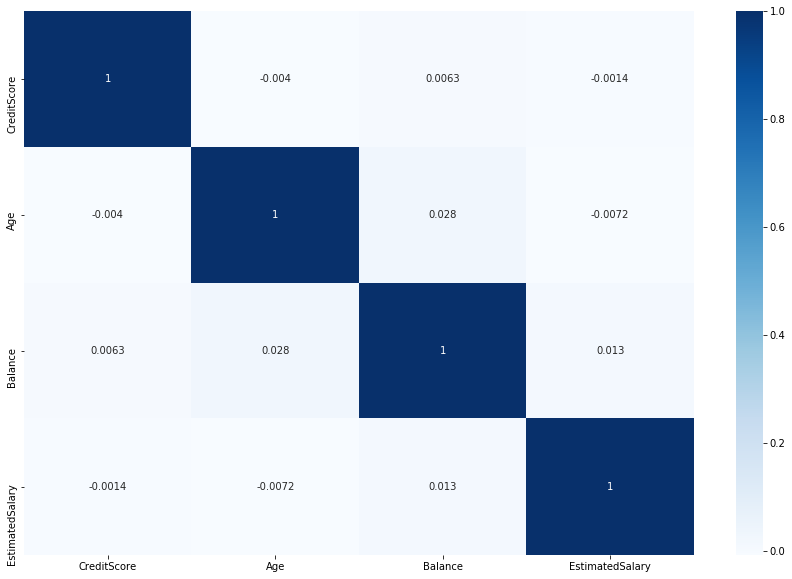

In [16]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_continous.corr(), xticklabels=df_continous.corr().columns,
         yticklabels=df_continous.corr().columns, cmap="Blues", annot = True)
plt.show()

Heatmap pokazaję nam, że nie ma na tyle dużej korelacji pomiędzy dwoma zmiennymi ciągłymi, żeby pozwolić sobie na redukcję wymiarowości. Jedyne, na co możemy zwrócić uwagę, to dodatnia korelacja między wiekiem, a stanem konta.

Aby sprawdzić korelację między zmiennymi ciągłymi, a naszym targetem do predykcji, którym jest kategoryczna zmienna binarna, użyjemy lekko zmodyfikowanej wersji współczynniku korelacji Pearson'a, zwanym punktowym biserialnym współczynnikiem korelacji. Nie wdając się w matematyczne szczegóły przyjmujemy milcząco, że każda z naszych zmiennych ciąŋłych jest m.in. z rozkładu normalnego i obliczamy, że:

In [18]:
df_continous_with_target = df[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']]

In [19]:
point_biserial_r = lambda x: np.round(pointbiserialr(x, df_continous_with_target.Exited),4)
df_continous_with_target.drop("Exited", axis=1).apply(point_biserial_r)

,CreditScore,Age,Balance,EstimatedSalary
0,-0.0271,0.2853,0.1185,0.0121
1,0.0067,0.0000,0.0000,0.2264


# Histogramy zmiennych

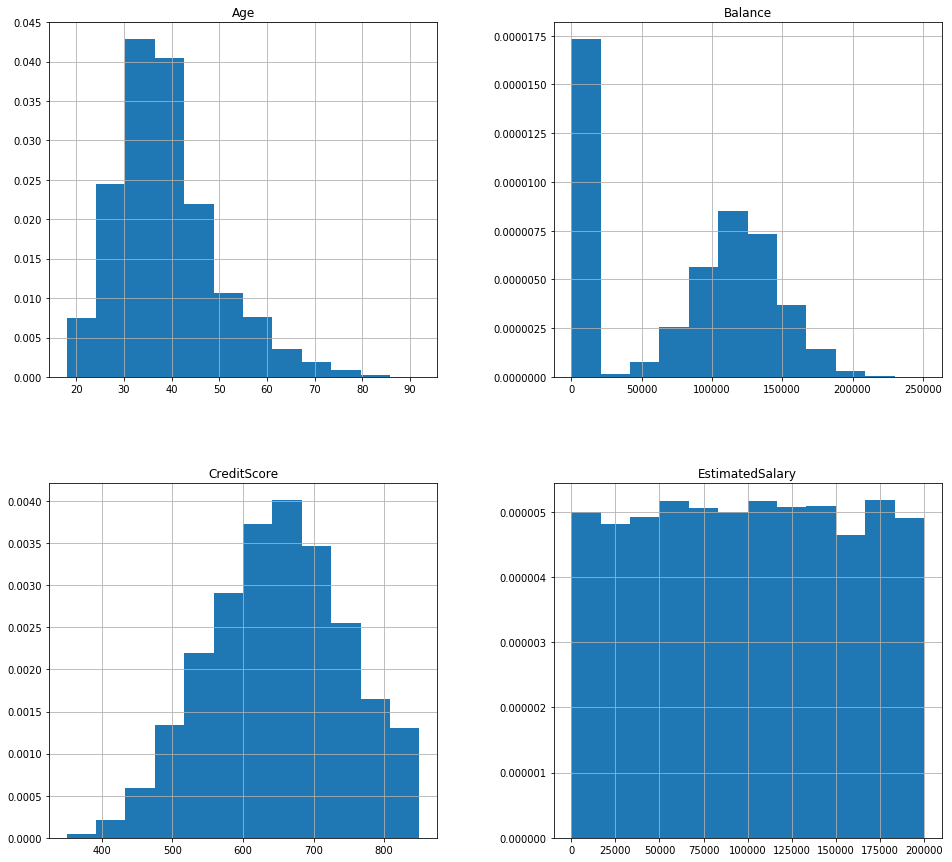

In [21]:
df_continous.hist(figsize=(16,15), bins = 12, density=True);
plt.show();



Na podstawie histogramów, możemy zauważyć, że wiek,  credit score zdają się być z rozkładu normalnego, a szacowana pensja jest z rozkładu jednostajnego. Podejrzany jest rozkład stanu konta. Od pewnej części wydaje się on być z rozkładu normalnego, lecz pojawia się bardzo wysoki słupek w okolicach zera, co może świadczyć o dużej ilości kont z brakiem środków - spowodowane to jest być może tym, że wsród zbioru danych występują również konta nieaktywne.
Pozostałe zmienne są kategoryczne.


# Pairploty 

Wykonam kilka pairplotow, by zobaczyć, jak różne cechy wpływają na nasz target.


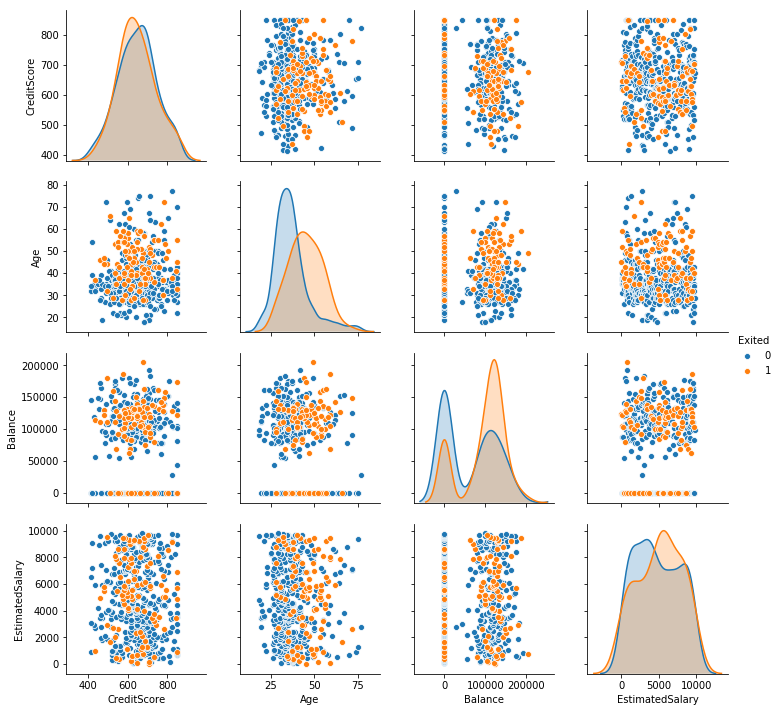

In [46]:
a = ['CreditScore','Age','Balance','EstimatedSalary']
sns.pairplot(df_continous_with_target.iloc[0:500,:], hue='Exited', x_vars=a, y_vars=a)
plt.show()

## Zmienne kategoryczne

* **Geography** - kraj pochodzenia klienta.
* **Gender** - płeć.
* **NumOfProducts** - liczba usług bankowych z których korzysta klient.
* **Tenure** - jak długo klient jest związany z bankiem(<b>w latach</b>).
* **HasCrCard** - zmienna określająca czy klient posiada w banku kartę kredytową, <b>1 = tak, 0 = nie</b>
* **IsActiveMember** - czy klient jest aktywnym członkiem banku, <b>1 = tak, 0 = nie</b>
* **Exited** - czy klient zrezygnował z usług banku. <b> 1 = tak, 0 = nie </b>

In [23]:
df_categorical = df[['Geography', 
                     'Gender','NumOfProducts','Tenure',
                     'HasCrCard','IsActiveMember','Exited']]

In [24]:
df_categorical.head()

,Geography,Gender,NumOfProducts,Tenure,HasCrCard,IsActiveMember,Exited
2362,Germany,Male,1,4,1,1,1
9647,France,Male,2,5,0,1,0
9010,Germany,Female,2,8,0,0,1
5548,France,Male,2,2,1,0,0
4989,France,Male,1,9,1,0,0


## Stwórzmy wykres słupkowy każdej ze zmiennej sumując liczność każdej z jej kategorii

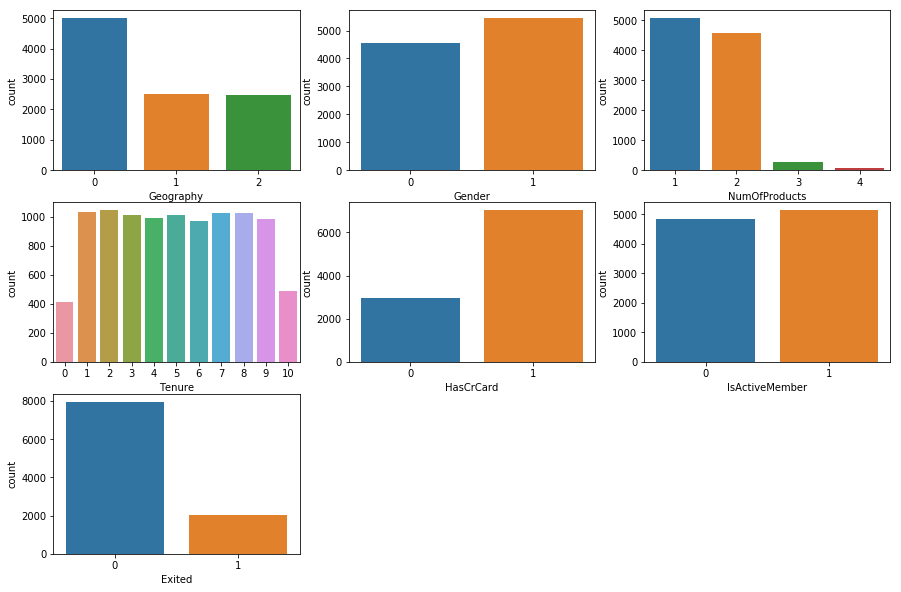

In [45]:
plt.figure(figsize=(15,10))
for i in range(1, 8):
    plt.subplot(3, 3, i)
    sns.countplot(x=df_categorical.columns[i-1], data=df_categorical)
plt.show()

### Nasuwa się kilka szybkich wniosków:
1. Rzadko kiedy klient korzysta z więcej niż dwóch usług bankowych.
2. Większość użytkowników banku ma kartę kredytową.
3. Liczba aktywnych, jak i nieaktywnych członków banku jest mniej więcej równa - to wyjaśnia, dlaczego stan konta wydaje się mieć rozkład normalny, lecz jest silnie zaburzony dużą liczbą kont z zerowym saldem.
4. Więcej mężczyzn niż kobiet ma konto w banku( o kilka-kilkanaście procent).
5. Najczęstszymi klientami danego banku są Franzuci.

## Przyjrzyjmy się samemu targetowi

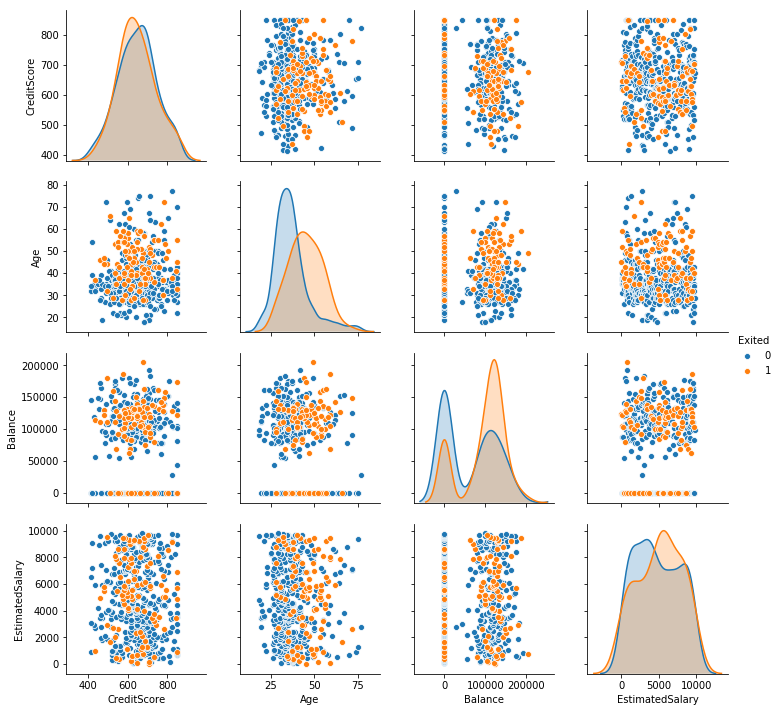

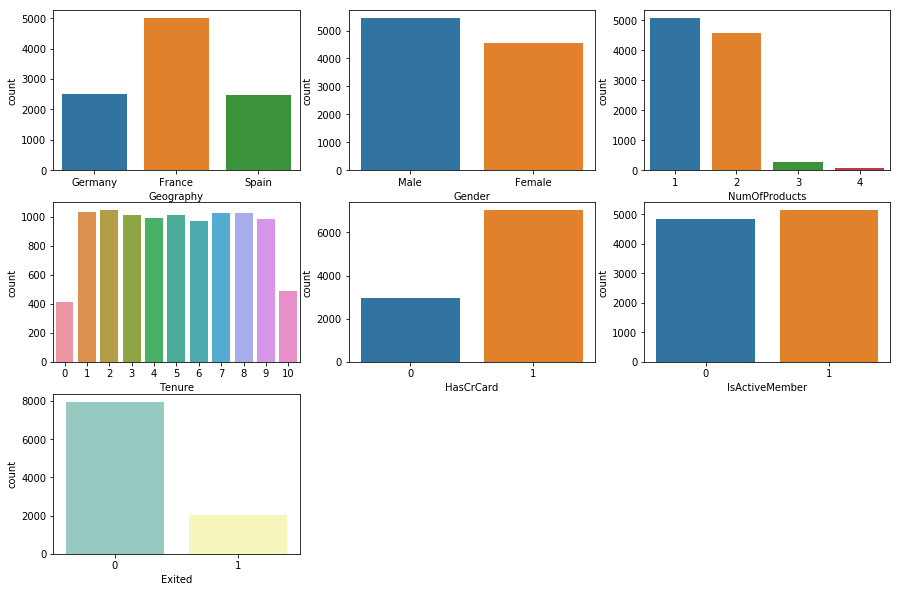

In [26]:
#Liczności zmiennej opisującej wyjście lub pozostanie w banku
ax = sns.countplot(x='Exited', data=df, palette='Set3')
df.loc[:,'Exited'].value_counts()
plt.show()

Jak widać zdecydowana większość badanych klientów nie zrezygnowała z usług banku.


# Zależności między zmiennymi kategorycznymi

Korelacja Pearsona nie jest odpowiednią metodą dla badania zależności między kategorycznymi zmiennymi ze skończoną liczbą wartości. Użyjmy do tego celu testu niezależności chi-kwadrat - Hipotezą zerową jest to, że nie ma zależności pomiędzy dwoma zmiennymi. Ustawiamy przedział ufności na poziomie 95% i sprawdzamy, czy istotnie występują jakieś zależności pomiędzy poszczególnymi zmiennymi kategorycznymi a celem predykcji.

<hr>
<br>
<center>Pozostaje zakodować dane kategoryczne dotyczące płci i kraju pochodzenia. <br>Użyję do tego dummy encodingu. <br>
</center>
Musimy zmienić wartości w dwóch kolumnach:

Gender: Female -> 0, Male -> 1

Geography: France -> 0, Germany -> 1, Spain -> 2

In [27]:
df_categorical.Gender = df.Gender.astype("category").cat.codes
df_categorical.Geography = df.Geography.astype("category").cat.codes

D:\Games\Anaconda\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [30]:
chi_squared = pd.DataFrame(
    chi2(df_categorical.values, df_categorical['Exited'].values), 
    columns = df_categorical.columns, 
    index = ['Chi2 Statistic', 'p-value']
)

### Sprawdźmy wyniki

In [32]:
chi_squared

,Geography,Gender,NumOfProducts,Tenure,HasCrCard,IsActiveMember,Exited
Chi2 Statistic,11.853251,5.153993e+01,5.055394,3.270538,0.150041,1.181994e+02,7963.0
p-value,0.000576,7.015575e-13,0.024549,0.070534,0.698496,1.568036e-27,0.0


Tylko dwie zmienne mają p-wartość powyżej poziomu 0.05 - staż oraz posiadanie karty kredytowej - pozwala to do postępowania tak, jakby nie było żadnego dowodu na odrzucenie hipotezy zerowej( "nie ma zależności pomiędzy dwoma zmiennymi"). W reszczie przypadków postępujemy tak jakbyśmy tą hipotezę odrzucili, czytaj: nie ma podstaw do tego, aby stwierdzić, że zależność nie występuje. Daje to nam w sumie 4 zmienne kategoryczne( na 6), które mogą mieć istotny wpływ na predykcję.

# Podsumowanie
 
 1. Mamy kilka osób, które mają bardzo niskie roczne przychody. Może to wynikać z różnych czynników. 
 <br> Model można zbudować z nimi i bez nich, jednak przy tak małej liczbie nie powinno mieć to znaczenia. 
 2. Saldo bankowe ma niecodzienny rozkład. Wiele wartości oscyluje koło zera (<b>3617</b>). 
 3. Osoby z dwoma usługami w banku są zdecydowanie bardziej skłonne, by pozostać jego klientami.
 4. Osoby z większym Creditscorem są bardziej skłonne do zmianny banku.
 


# Czas na model!

## Zakodujmy tylko jeszcze pochodzenie i płeć klienta w całym zbiorze danych, tak jak to zrobiliśmy w w zbiorze danych dla zmiennych kategorycznych

In [33]:
df.Gender = df.Gender.astype("category").cat.codes
df.Geography = df.Geography.astype("category").cat.codes

In [34]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2362,709,1,1,45,4,122917.71,1,1,1,11.58,1
9647,625,0,1,31,5,0.00,2,0,1,90.07,0
9010,645,1,0,59,8,121669.93,2,0,0,91.75,1
5548,710,0,1,38,2,0.00,2,1,0,96.27,0
4989,629,0,1,40,9,0.00,1,1,0,106.67,0


## Tworzymy zbiór treningowy i testowy, standaryzujemy i stratyfikujemy odpowiednio do proporcji etykiet

In [35]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Games\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  import sys
D:\Games\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Games\Anaconda\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


## Tak utworzone zbiory danych zapiszmy do plików .csv, aby swobodnie importować je do naszych modeli

In [36]:
X.to_csv('data/cleaned_data.csv')
y.to_csv('data/labels.csv')
pd.DataFrame(X_train_std).to_csv('data/X_train_std.csv')
pd.DataFrame(X_test).to_csv('data/X_test.csv')
pd.DataFrame(X_train).to_csv('data/X_train.csv')
pd.DataFrame(X_test_std).to_csv('data/X_test_std.csv')
pd.DataFrame(y_train).to_csv('data/y_train.csv')
pd.DataFrame(y_test).to_csv('data/y_test.csv')

D:\Games\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


## Jeden z modelów nie korzysta z jednej ze zmiennych( posiadanie karty kredytowej) - przygotujmy zatem zbiór danych bez niej

In [37]:
X_train_without_cr_card = X_train.drop(['HasCrCard'], axis=1)
scaler_without_cr_card = StandardScaler().fit(X_train_without_cr_card)
X_train_std_without_cr_card = scaler_without_cr_card.transform(X_train_without_cr_card)

D:\Games\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Games\Anaconda\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


## Wczytajmy utworzone modele i obliczmy 

In [43]:
def _load_model(model_name):
    clear_session()
    dependencies = {
        'binary_precision': keras_metrics.precision(),
        'accuracy': 'accuracy'
    }
    path = 'saved_models/{0}.h5'.format(model_name)
    nn = load_model(path, custom_objects=dependencies)
    print('{0} z lokalizacji: {1}'.format(nn.name, path))
    return nn

def evaluate_model(model_name):
    nn = _load_model(model_name)
    scores = nn.evaluate(X_std_without_cr_card, y, verbose=0) if nn.name == 'model_2' else nn.evaluate(X_test_std, y_test, verbose=0)
    return {
        'Name': model_name,
        'Precision (%)': np.round(scores[1]*100,3),
        'Accuracy (%)': np.round(scores[2]*100,3)
    }


In [40]:
list_of_models = ['model_1', 'model_2', 'model_3']

## Czas sprawdzić wyniki nszych modeli na zbiorze treningowym

In [41]:
results = pd.DataFrame([evaluate_model(model_name) for model_name in list_of_models])
results.set_index('Name', inplace=True)

NameError: name 'clear_session' is not defined

## Wyniki

In [42]:
results

NameError: name 'results' is not defined